# Data exploration of the Climate TRACE dataset

In this chapter, we look at the dataset and we answer a few questions:
- which countries are the biggest emitters?
- what sectors are the most responsible for emissions?

In a second part, we compare two different views on emissions:

- the _source_ view, which looks from a bottom up view at all the sources (factories, mines, farms, ...)
- the _country_ view, which is a top down approach, and derives many values from aggregate economic activity, for example how many tons of coal were burned to produced annually. This is  the official reporting method followed by countries to report their emissions to the United Nations as part of the Paris agreements.

The data has already been prepared from the original Climate TRACE dataset. If you want to understand the preprocessing, read the chapter [Ingestion](./ingestion.ipynb).


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

We import all the libraries that we will use in this notebook:
- the [Polars](https://pola.rs/) library, a very fast package with a clear interface.
- the [Plotly Express](https://plotly.com/python/plotly-express/) visualization library
- the `ctrace` package (included in this repository), that contains tools to read and understand the Climate TRACE data.

In [3]:
import polars as pl
import plotly.io
plotly.io.templates.default = "plotly_white"
import plotly.express as px

from ctrace.constants import * # We import many useful constants
import ctrace as ct

# Country emissions

The country emissions are available through the `read_country_emissions()` function. This function will download by default the latest set of reports (currently the V3, publised in November 2024). If the data has already been downloaded, it will use this copy.

The format being returned is a Polars `DataFrame`. This format will be very familiar to people used to working with Pandas, Spark or R dataframes. The `GAS_LIST` indicates that we want to load all the gases available.


In [4]:
cedf = ct.read_country_emissions(GAS_LIST)

In [5]:
cedf.head(3)

shape: (3, 11)
┌────────────┬────────────┬────────────┬──────┬───┬────────────┬───────────┬───────────┬───────────┐
│ iso3_count ┆ start_time ┆ end_time   ┆ gas  ┆ … ┆ emissions_ ┆ temporal_ ┆ created_d ┆ modified_ │
│ ry         ┆ ---        ┆ ---        ┆ ---  ┆   ┆ quantity_u ┆ granulari ┆ ate       ┆ date      │
│ ---        ┆ datetime[m ┆ datetime[m ┆ enum ┆   ┆ nits       ┆ ty        ┆ ---       ┆ ---       │
│ enum       ┆ s, UTC]    ┆ s, UTC]    ┆      ┆   ┆ ---        ┆ ---       ┆ datetime[ ┆ datetime[ │
│            ┆            ┆            ┆      ┆   ┆ cat        ┆ enum      ┆ ms, UTC]  ┆ ms, UTC]  │
╞════════════╪════════════╪════════════╪══════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ ABW        ┆ 2015-01-01 ┆ 2015-12-31 ┆ co2  ┆ … ┆ null       ┆ annual    ┆ null      ┆ null      │
│            ┆ 00:00:00   ┆ 00:00:00   ┆      ┆   ┆            ┆           ┆           ┆           │
│            ┆ UTC        ┆ UTC        ┆      ┆   ┆            ┆           ┆           ┆           │
│ ABW        ┆ 2015-01-01 ┆ 2015-12-31 ┆ co2  ┆ … ┆ null       ┆ annual    ┆ null      ┆ null      │
│            ┆ 00:00:00   ┆ 00:00:00   ┆      ┆   ┆            ┆           ┆           ┆           │
│            ┆ UTC        ┆ UTC        ┆      ┆   ┆            ┆           ┆           ┆           │
│ ABW        ┆ 2015-01-01 ┆ 2015-12-31 ┆ co2  ┆ … ┆ null       ┆ annual    ┆ null      ┆ null      │
│            ┆ 00:00:00   ┆ 00:00:00   ┆      ┆   ┆            ┆           ┆           ┆           │
│            ┆ UTC        ┆ UTC        ┆      ┆   ┆            ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴──────┴───┴────────────┴───────────┴───────────┴───────────┘

# Understanding the data format

These rows are a mouthful to digest. Here is how the emissions data is structured.

This data is highly structured, which is reflected in the schema itself. This schema has a lot of enumerations (`iso3_country`, `gas`, ...), where only a few values are expected. For example, all the country names are represented by their official [ISO 3166 3-letter country codes](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes). Internally, Polars can assign small integers to represent them all, which consumes less memory and speeds up manipulations. This has a further advantage: since we know the values to expect, we can give them names in the code such as `CH4`, `CO2`, .... We can use all the software tools to find and update references to various gas as we work with it. 

```{admonition} TODO
move all this part in its own notebook, this is about technical details
```


In [6]:
cedf.schema

Schema([('iso3_country',
         Enum(categories=['ABW', 'AFG', 'AGO', 'AIA', 'ALA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM', 'ATA', 'ATF', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BES', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLM', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BVT', 'BWA', 'CAF', 'CAN', 'CCK', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CUW', 'CXR', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GGY', 'GHA', 'GIB', 'GIN', 'GLP', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUF', 'GUM', 'GUY', 'HKG', 'HMD', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IMN', 'IND', 'IOT', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC

Another trick is to define all the Dataframe _columns_ that we are going to manipulate.
For example, there is a column called `gas` that refers to all the gas being tabulated.
Coming from the Pandas world, it would be normal to refer to this column:

```py
cedf_pdf[cedf_pdf["gas"]=="ch4"]
```

Polars offers a more succint syntax by considering an _abstract column_, for example for the gas:

In [7]:
pl.col("gas")

<Expr ['col("gas")'] at 0x700D4BB32E30>

That `col("gas")` refers to any dataframe column called `gas`. The `select` method operates on a polars dataframe takes such columns as instructions to select specific columns.

In [8]:
cedf.select(pl.col("gas"));

The `ctrace` library predefines all the columns defined in the Climate TRACE datasets, all prefixed by the `c_` prefix:

In [9]:
ct.constants.c_gas

<Expr ['col("gas")'] at 0x700D4BFEF310>

This reduces the chance of making a typo, allows us to use the autocompletion features of editors, and it will catch any mistake before executing the code. Selecting all the data related to CO2 is simply:

In [10]:
# cedf.filter(c_gas == CO2);

**Using a different data processing framework**

This notebook is using Polars. Are you more familiar with other frameworks such as `pandas`, `PySpark`, `Modin`, `DuckDB`, R's dataframes? No problem. Polars can convert directly to most of these other representations. Here is an example for pandas below. You can also directly point to the underlying Parquet representation on the [HuggingFace Hub of the project](https://huggingface.co/datasets/tjhunter/climate-trace/tree/main).

In [11]:
# Use pandas instead:
cedf_pandas = ct.read_country_emissions(GAS_LIST).to_pandas()
cedf_pandas.head(3)

iso3_country                start_time                  end_time  gas  \
0          ABW 2015-01-01 00:00:00+00:00 2015-12-31 00:00:00+00:00  co2   
1          ABW 2015-01-01 00:00:00+00:00 2015-12-31 00:00:00+00:00  co2   
2          ABW 2015-01-01 00:00:00+00:00 2015-12-31 00:00:00+00:00  co2   

                   sector                     subsector  emissions_quantity  \
0  fossil-fuel-operations  other-fossil-fuel-operations            0.000000   
1      mineral-extraction                bauxite-mining            0.000000   
2          transportation             domestic-shipping        90613.375994   

  emissions_quantity_units temporal_granularity created_date modified_date  
0                      NaN               annual          NaT           NaT  
1                      NaN               annual          NaT           NaT  
2                      NaN               annual          NaT           NaT

# Country checks

In this section, we identify the biggest emitters and sort out a few unexpected insights.

We focus this analysis on the year *2023* and on the aggregated emissions for carbon dioxyde (CO2). You can look at how the results change when you focus on another specific gas (`co2`, `nh4`, ...) or the global warming potentials (`co2e_100yr`)

In [12]:
gas = CO2 #gas = CO2E_100YR
year = 2023

cedf_gy = cedf.filter(c_gas == gas).filter(c_start_time.dt.year()==year)

First question: how much do we emit? About 50GT of CO2 (gigatonnes of CO2). Note the first wrinkle already: this takes into account the absorption by the vegetation. If we did not take into action the beneficial actions of our friends the trees, our emissions would be already higher. Trees will come back as a complicated topic.

Here are the net emissions, taking into account all the contribution of the forestry and land use sector: 55GT of CO2 equivalent

In [13]:
cedf_gy.select(c_emissions_quantity.sum())

shape: (1, 1)
┌────────────────────┐
│ emissions_quantity │
│ ---                │
│ f64                │
╞════════════════════╡
│ 5.0609e10          │
└────────────────────┘

Looking at the increase by year, we see that the emissions of CO2 are still increasing.

In [14]:
px.line(
    cedf
        .filter(c_emissions_quantity > 0)
        .group_by(c_start_time.dt.year(), c_gas)
        .agg(c_emissions_quantity.sum())
        .sort(by=c_start_time),
    x="start_time", y="emissions_quantity",
    color="gas")

Most reports do not account for the forestry and land use, because it is very hard to measure and because there are still some debates on what exactly to report in that category. Excluding this category, we get to a amount of 46GT CO2 equivalent, which is what Climate TRACE reports on its website:

In [15]:
(cedf_gy
 .filter(c_sector != FORESTRY_AND_LAND_USE)
 .select(c_emissions_quantity.sum()))

shape: (1, 1)
┌────────────────────┐
│ emissions_quantity │
│ ---                │
│ f64                │
╞════════════════════╡
│ 4.6174e10          │
└────────────────────┘

For now, we will still include forestry and land use. You will see how much this can skew the figures and why it is at the center of many discussions.

And when splitting between sinks and sources

In [16]:
(
    cedf_gy
    .select([c_emissions_quantity])
    .with_columns((c_emissions_quantity > 0).alias("is_source"))
    .group_by("is_source")
    .agg(c_emissions_quantity.sum())
    .drop_nulls()
)


shape: (2, 2)
┌───────────┬────────────────────┐
│ is_source ┆ emissions_quantity │
│ ---       ┆ ---                │
│ bool      ┆ f64                │
╞═══════════╪════════════════════╡
│ true      ┆ 6.6481e10          │
│ false     ┆ -1.5872e10         │
└───────────┴────────────────────┘

Look at the top emitters for all the emissions sources. The usual suspects
come at the top (China, USA, Russia). However, it is very important to
keep the orders of magnitude in mind: China has more emissions than the next 3 countries (USA, Russia, India) _combined_.

In [17]:
px.bar(cedf_gy
    .filter(c_emissions_quantity > 0)
    .group_by(c_iso3_country)
    .agg(c_emissions_quantity.sum())
    .sort([c_emissions_quantity], descending=True)
    .head(20)
,x=ISO3_COUNTRY, y=EMISSIONS_QUANTITY,log_y=False)


Looking at each sector gives quickly a nuanced sector and shows the difference
between the various countries.

- the Chinese electricity sector emits more than Western Europe combined. This is not to say that Europeans should not make efforts - they should!. But these efforts can come from many ways, such as incentivizing China to reduce the role of coal in its domestic supply of electricity.

- the emissions from the oil and gas sector in Russia is bigger than all the emissions of Germany. These emissions are typically quick wins (fixing leaks on old pipes).

- Zimbabwe and Mozambique have as much gross emissions together as Japan! Clearing forested areas are very bad for the climate and have only short-term economic benefits. Finding fairer ways to preserve natural resources would also go a long way towards helping developing countries achieve their goals.

- France is about twice as big as Russia looking at the economy (GDP), yet it contributes much less. This view emphasizes _direct_ emissions (where gases are emitted), not the _indirect_ emissions from consumption.

```{admonition} CTODO
:name: sec-emissions2
Check these conclusions with experts
```


In [18]:
px.bar(cedf_gy
    .group_by(c_iso3_country, c_subsector)
    .agg(c_emissions_quantity.sum())
    .sort([c_emissions_quantity], descending=True)
    .filter(c_iso3_country.is_in([
        "CHN", "USA", "IND", "RUS","MOZ","FRA", "NLD"]))
,x=ISO3_COUNTRY, y=EMISSIONS_QUANTITY,color=SUBSECTOR,log_y=False)

## Source checks

Let's look now at all the sources tracked by Climate TRACE.

We load the data first.

```{note}

Technical

- We load the data using `scan_parquet`. This instructs Polars to delay the actual loading in memory until requested. The amount of memory necessary will then be minimal, even if the dataset itself is 4GB.

- We reset the schema, in particular we add all the information about enumerations. This provides better type checks and helps Polars with optimizing its queries.

```

You can see that Polars has not done any processing if you attempt to display the data:

In [19]:
sdf_gy = ct.read_source_emissions(gas=gas, year=year)
sdf_gy

How much emissions are released according to the source tracking? This number is significantly higher compared to what was estimated per country (57GT CO2 instead of 41GT CO2). 

The forestry and land use category is notoriously hard to estimate, so we are going for now to leave it aside

In [20]:
(sdf_gy
 .filter(c_sector != FORESTRY_AND_LAND_USE)
 .select(c_emissions_quantity.sum())
 .collect()
)

shape: (1, 1)
┌────────────────────┐
│ emissions_quantity │
│ ---                │
│ f64                │
╞════════════════════╡
│ 5.7449e10          │
└────────────────────┘

### The biggest sources

What are the biggest sources of emissions? Fossil fuel operations (the Permian bassin in Texas, oil fields in Russia) are amongst the largest sources. Agriculture also plays a huge role, especially Brazil and India.

In [21]:
(sdf_gy
.filter(c_emissions_quantity > 0)
.filter(c_sector != FORESTRY_AND_LAND_USE)
 .group_by(c_source_id)
 .agg(c_iso3_country.first(), c_sector.first(), c_subsector.first(), c_emissions_quantity.sum(), c_source_name.first())
.top_k(50, by=c_emissions_quantity)
.collect(streaming=True))

shape: (50, 6)
┌───────────┬──────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┐
│ source_id ┆ iso3_country ┆ sector          ┆ subsector       ┆ emissions_quant ┆ source_name     │
│ ---       ┆ ---          ┆ ---             ┆ ---             ┆ ity             ┆ ---             │
│ u64       ┆ enum         ┆ enum            ┆ enum            ┆ ---             ┆ str             │
│           ┆              ┆                 ┆                 ┆ f64             ┆                 │
╞═══════════╪══════════════╪═════════════════╪═════════════════╪═════════════════╪═════════════════╡
│ 1241948   ┆ CHN          ┆ buildings       ┆ residential-ons ┆ 5.9804e8        ┆ China           │
│           ┆              ┆                 ┆ ite-fuel-usage  ┆                 ┆                 │
│ 1242200   ┆ USA          ┆ buildings       ┆ residential-ons ┆ 4.6791e8        ┆ United States   │
│           ┆              ┆                 ┆ ite-fuel-usage  ┆                 ┆                 │
│ 3588448   ┆ RUS          ┆ fossil-fuel-ope ┆ oil-and-gas-tra ┆ 2.5986e8        ┆ Russian         │
│           ┆              ┆ rations         ┆ nsport          ┆                 ┆ Federation_West │
│           ┆              ┆                 ┆                 ┆                 ┆ Siberi…         │
│ 10720469  ┆ BRA          ┆ agriculture     ┆ cropland-fires  ┆ 2.2666e8        ┆ Brazil          │
│ 10720302  ┆ IND          ┆ agriculture     ┆ cropland-fires  ┆ 2.1886e8        ┆ India           │
│ …         ┆ …            ┆ …               ┆ …               ┆ …               ┆ …               │
│ 3597677   ┆ BRA          ┆ transportation  ┆ road-transporta ┆ 4.6394e7        ┆ São Paulo       │
│           ┆              ┆                 ┆ tion            ┆                 ┆                 │
│ 3588663   ┆ IRQ          ┆ fossil-fuel-ope ┆ oil-and-gas-pro ┆ 4.6277e7        ┆ Iraq_Widyan -   │
│           ┆              ┆ rations         ┆ duction         ┆                 ┆ North Arabian   │
│           ┆              ┆                 ┆                 ┆                 ┆ Gu…             │
│ 3600747   ┆ USA          ┆ transportation  ┆ road-transporta ┆ 4.5956e7        ┆ New York        │
│           ┆              ┆                 ┆ tion            ┆                 ┆                 │
│ 3588498   ┆ USA          ┆ fossil-fuel-ope ┆ oil-and-gas-tra ┆ 4.5931e7        ┆ United States_A │
│           ┆              ┆ rations         ┆ nsport          ┆                 ┆ ppalachian_Shal │
│           ┆              ┆                 ┆                 ┆                 ┆ …               │
│ 3600726   ┆ USA          ┆ transportation  ┆ road-transporta ┆ 4.5479e7        ┆ Illinois        │
│           ┆              ┆                 ┆ tion            ┆                 ┆                 │
└───────────┴──────────────┴─────────────────┴─────────────────┴─────────────────┴─────────────────┘

### Number of tracked sources

How many sources were tracked last year?

We get more than 1.2millions if the forestry and land use changes are included.

Technical:

Notice that we did not need to ingest the data in a database, and yet this query takes less than a second. Pretty good for a decently large dataset! Try to reproduce this analysis in Pandas and see what happens.


```{admonition} CTODO
:name: sec-emissions
The CT map seems to report 1.8M.
```


In [22]:
(sdf_gy.select(c_source_id.unique_counts())
 .count()
 .collect()
 .item() # Using .item() to have a single number
)

1265375

Excluding them, we get the number reported officially by Climate TRACE (748k).

In [23]:
(sdf_gy.filter(c_sector != FORESTRY_AND_LAND_USE)
.select(c_source_id.unique_counts())
 .count()
 .collect()
 .item()
)

749594

Which categories do these records come from?

This shows the full diversity of the sources to consider. The most numerous records concern ships, followed by various treatment plants for cities, forest statistics, etc.

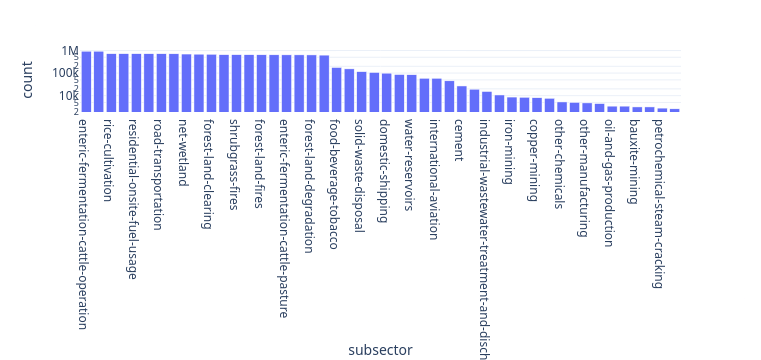

In [24]:
px.bar(sdf_gy
 .select(c_subsector.value_counts(sort=True))
 .collect()
 .unnest(SUBSECTOR),
      x=SUBSECTOR, y="count", log_y=True
)

Looking at a few examples of wastewater treatment plants, you see how the data is organized for each source:
- an identifier, along with country, UNFCCC sectorial categorization, time of data collection
- the gas considered
- the main methodology to get the emission: typically a certain quantity of interest, called _activity_ (here a population) multiplied by an _emission factor_
- more details about the source itself: name, type, position
- some extra tabular information (always strings in this dataset)
- qualitative confidence values for each of the values



In [25]:
(sdf_gy
 .filter(c_sector == MANUFACTURING)
 .filter(c_subsector == CEMENT)
 .head(3)
 .collect()
)

shape: (3, 55)
┌───────────┬────────────┬────────────┬───────────┬───┬────────────┬────────────┬───────────┬──────┐
│ source_id ┆ iso3_count ┆ sector     ┆ subsector ┆ … ┆ conf_activ ┆ conf_emiss ┆ conf_emis ┆ year │
│ ---       ┆ ry         ┆ ---        ┆ ---       ┆   ┆ ity        ┆ ions_facto ┆ sions_qua ┆ ---  │
│ u64       ┆ ---        ┆ enum       ┆ enum      ┆   ┆ ---        ┆ r          ┆ ntity     ┆ i64  │
│           ┆ enum       ┆            ┆           ┆   ┆ enum       ┆ ---        ┆ ---       ┆      │
│           ┆            ┆            ┆           ┆   ┆            ┆ enum       ┆ enum      ┆      │
╞═══════════╪════════════╪════════════╪═══════════╪═══╪════════════╪════════════╪═══════════╪══════╡
│ 1895560   ┆ CHN        ┆ manufactur ┆ cement    ┆ … ┆ low        ┆ low        ┆ low       ┆ 2023 │
│           ┆            ┆ ing        ┆           ┆   ┆            ┆            ┆           ┆      │
│ 1895560   ┆ CHN        ┆ manufactur ┆ cement    ┆ … ┆ low        ┆ low        ┆ low       ┆ 2023 │
│           ┆            ┆ ing        ┆           ┆   ┆            ┆            ┆           ┆      │
│ 1895560   ┆ CHN        ┆ manufactur ┆ cement    ┆ … ┆ low        ┆ low        ┆ low       ┆ 2023 │
│           ┆            ┆ ing        ┆           ┆   ┆            ┆            ┆           ┆      │
└───────────┴────────────┴────────────┴───────────┴───┴────────────┴────────────┴───────────┴──────┘

Looking now at emissions and gathering by country, we get a plot relatively similar to what we saw in the section above.


Again, France and the Netherlands barely appear in this graph, and Mozambique's forest management practices have an enormous impact.

In [26]:
px.bar(
(sdf_gy
.group_by(c_iso3_country, c_subsector)
 .agg(c_emissions_quantity.sum())
     .sort([c_emissions_quantity], descending=True)
 .filter(c_iso3_country.is_in(["CHN", "USA", "IND", "RUS","MOZ","FRA", "NLD"]))
 .collect()
)
    ,x=ISO3_COUNTRY, y=EMISSIONS_QUANTITY,color=SUBSECTOR,log_y=False)

Looking by sector, it is easy to see why the forestry and land use sector is complex: it would dominate both in
retention and in emission.

In [27]:
px.bar(
(sdf_gy
.group_by(c_sector, c_subsector)
 .agg(c_emissions_quantity.sum())
     .sort([c_emissions_quantity], descending=True)
 .collect()
)
    ,x=SECTOR, y=EMISSIONS_QUANTITY,color=SUBSECTOR,log_y=False)

## Conclusion

In this section, we saw:
- how to access the Climate TRACE dataset in a modern data processing tool (Polars)
- how to produce high-level statistics per country and per sector

From the data, it should be clear that tackling emissions is a global issue, in which a few countries dominate.
Some countries with large economic outputs (France, The Netherlands) can have minimal emissions, in part because they have low-emission means of producing electricity and they have outsourced their industries. Some others with comparably small economic outputs or populations (ex: Mozambique) have a disproportionate impact because of the changes occurring in their ecosystems.

```{seealso} Exercise
Take your country look at the sources of emissions and explore how the different gases provide different perspectives.
```